In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)


print(proj_root)

d:\Work\repos\RL\phd-rl-algos


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from dqn.opinion_dynamics.utils.experiment import build_environment, EnvironmentFactory
from dqn.opinion_dynamics.experiments.baseline import run_policy, run_centrality_policy, flatten_intermediate_states_np

from dynamic_programming.opinion_dynamics.algos import compute_average_error, compute_final_average_error, generate_full_control_policy, generate_control_from_vector
from dynamic_programming.opinion_dynamics.algo_infinite_horizon import value_iteration, extract_policy, create_state_grid
from dynamic_programming.opinion_dynamics.common.viz import plot_opinions_over_time, visualize_policy_from_env, plot_action_heatmap, interpolate_opinion_trajectory


C:\Users\Chainsword\AppData\Local\Temp\ipykernel_36752\4032120892.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd



--- Running simulation for validation environment version 0 ---
Policy run terminated after 75 steps. Done=False, Truncated=True


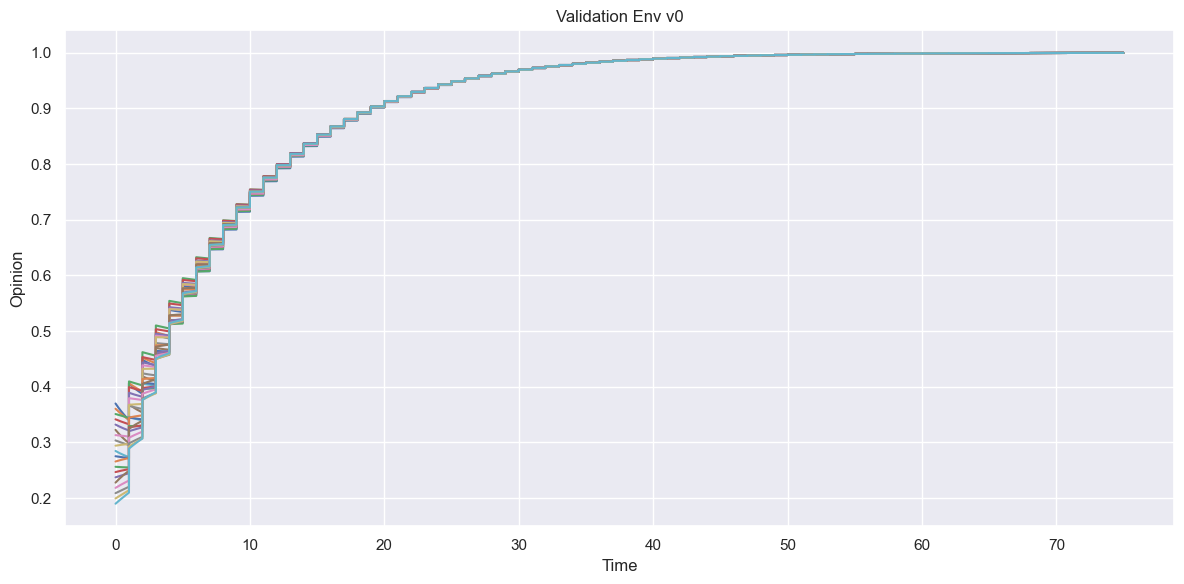

Total discounted reward: -12.6313

--- Running simulation for validation environment version 1 ---
Policy run terminated after 75 steps. Done=False, Truncated=True


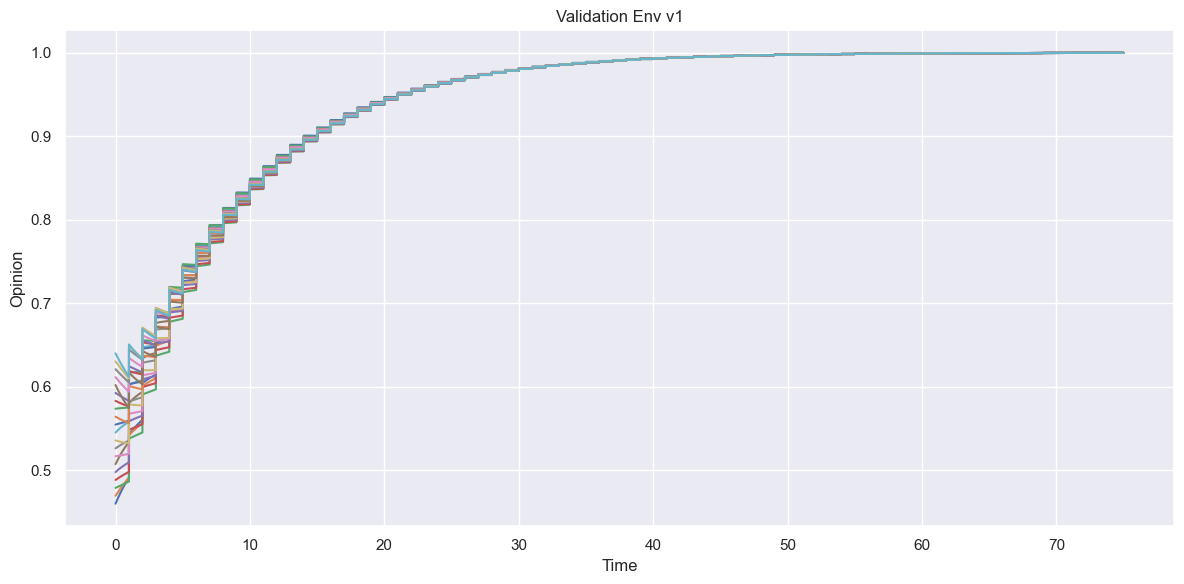

Total discounted reward: -9.8903

--- Running simulation for validation environment version 2 ---
Policy run terminated after 75 steps. Done=False, Truncated=True


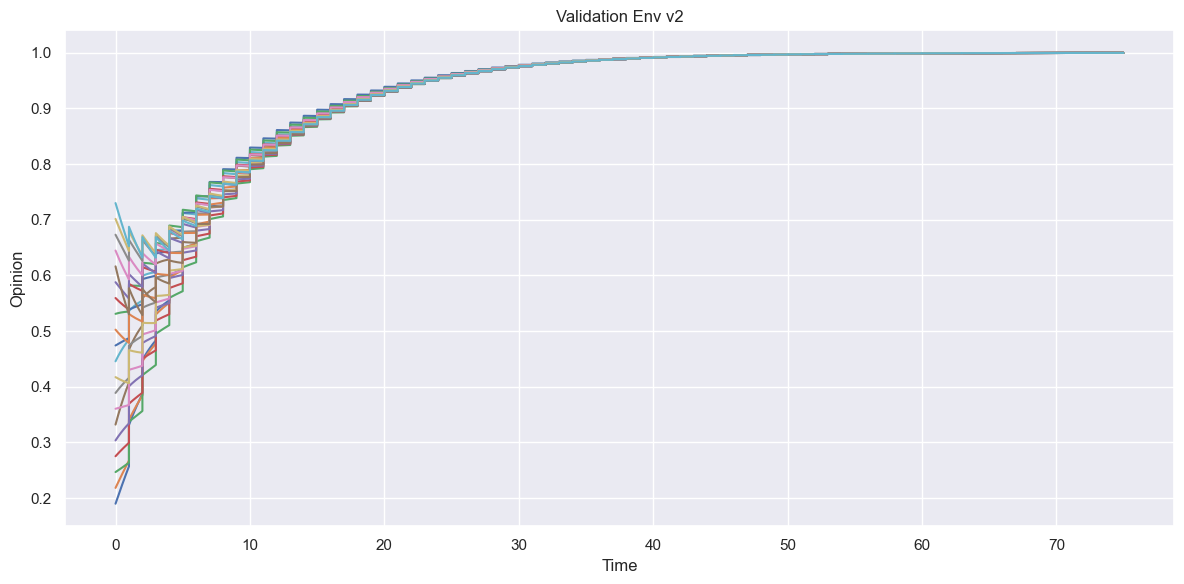

Total discounted reward: -10.8629
   version  discounted_reward
0        0         -12.631277
1        1          -9.890279
2        2         -10.862886


In [4]:


factory = EnvironmentFactory()
num_steps = 75
nx = 2
available_budget = 2
gamma = 0.99

results = []

for version in range(len(factory.validation_versions)):
    print(f"\n--- Running simulation for validation environment version {version} ---")
    
    env = factory.get_validation_env(version=version)

    # Define control policy (uniform in this example)
    policy_uniform = np.full(env.num_agents, available_budget / env.num_agents)
    policy_broadcast = generate_control_from_vector(env, nx, policy_uniform)

    # Run policy (returns intermediate states too)
    opinions_over_time, time_points, rewards, actions, all_intermediate_states = run_policy(
        env, policy_broadcast, nx=nx, max_steps=num_steps
    )

    # Flatten the fine-grained intermediate states for plotting
    flat_states, flat_times = flatten_intermediate_states_np(
        all_intermediate_states, t_campaign=env.t_campaign, t_s=env.t_s
    )

    # Plot the high-resolution opinion trajectories
    plot_opinions_over_time(flat_states, time_points=flat_times, title=f"Validation Env v{version}")

    # Compute total discounted reward
    total_value = sum((gamma**i) * r for i, r in enumerate(rewards))
    print(f"Total discounted reward: {total_value:.4f}")
    
    results.append({"version": version, "discounted_reward": total_value})
    
df_results = pd.DataFrame(results)
print(df_results)

-13.571547271364542


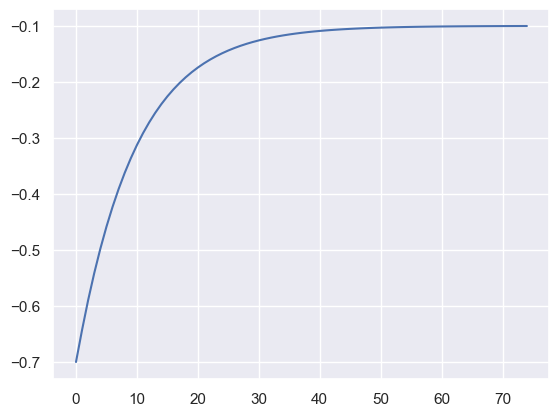

In [5]:
# plot rewards with seaborn

sns.lineplot(x=np.arange(len(rewards)), y=rewards)
print(sum(rewards))


--- Running centrality policy for validation environment version 0 ---
Centrality-based policy finished after 74 steps. Done=False, Truncated=True


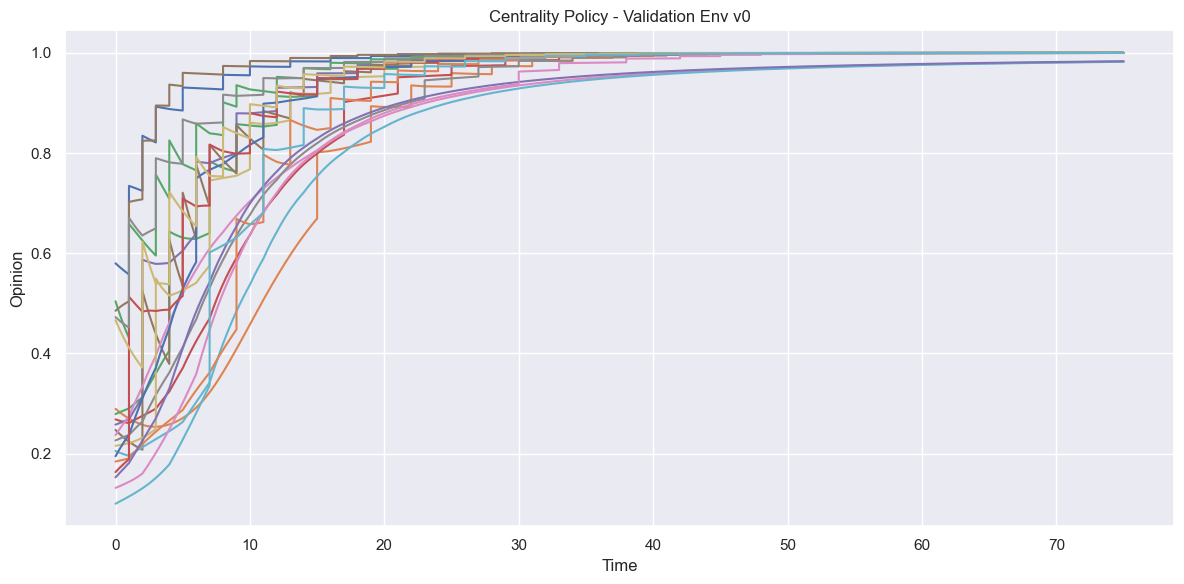

Total discounted reward: -11.9606

--- Running centrality policy for validation environment version 1 ---
Centrality-based policy finished after 74 steps. Done=False, Truncated=True


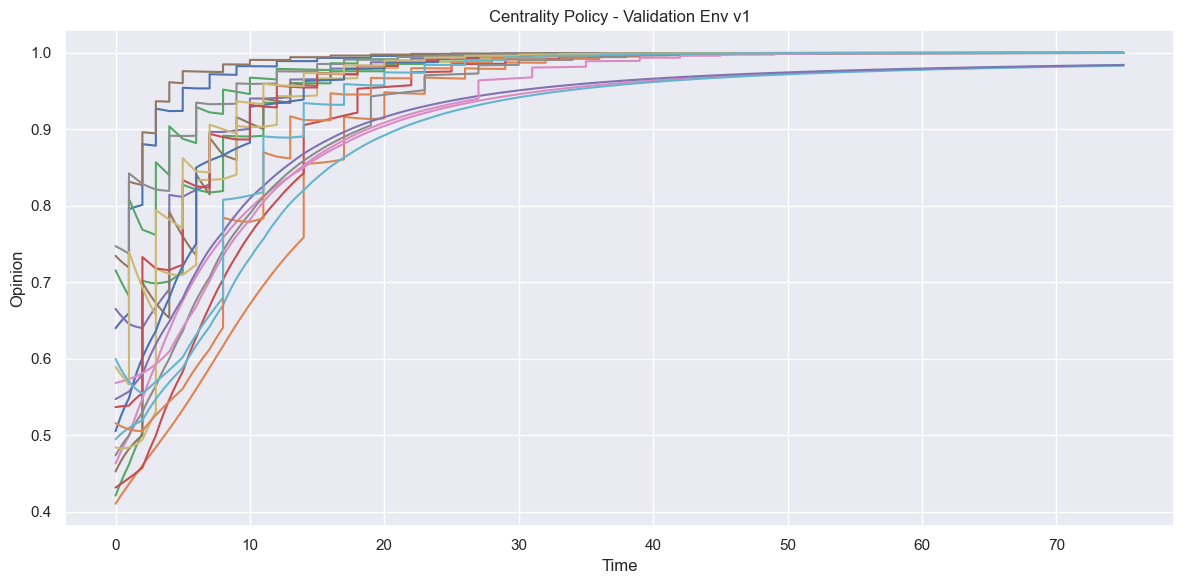

Total discounted reward: -9.3972

--- Running centrality policy for validation environment version 2 ---
Centrality-based policy finished after 74 steps. Done=False, Truncated=True


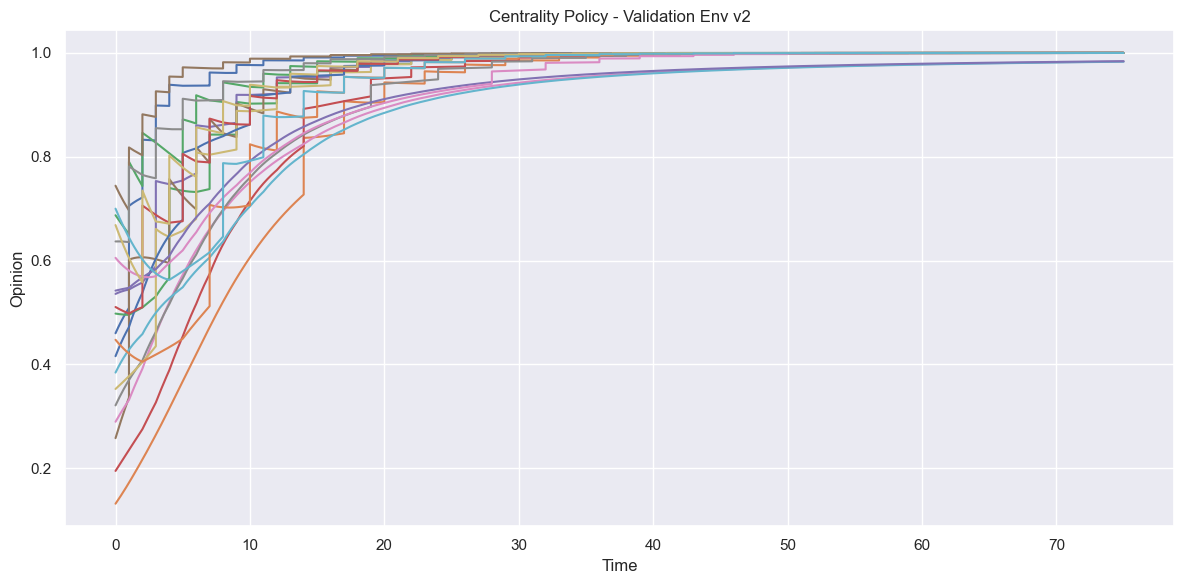

Total discounted reward: -10.0797
   version  discounted_reward
0        0         -11.960573
1        1          -9.397238
2        2         -10.079745


In [6]:
# --- Parameters ---
num_steps = 100
gamma = 0.99
available_budget = 2
nx = 2  # required for control vector construction

factory = EnvironmentFactory()
results = []

env_versions = factory.validation_versions
# env_versions = [0]

for version in range(len(env_versions)):
    print(f"\n--- Running centrality policy for validation environment version {version} ---")
    
    env = factory.get_validation_env(version=version)

    # --- Run centrality-based policy ---
    opinions_over_time, time_points, rewards, actions, intermediary_states = run_centrality_policy(
        env,
        available_budget=available_budget,
        max_steps=num_steps
    )

    # --- Flatten intermediate states for plotting ---
    flat_states, flat_times = flatten_intermediate_states_np(intermediary_states, env.t_campaign, env.t_s)

    # --- Plot ---
    plot_opinions_over_time(flat_states, flat_times, title=f"Centrality Policy - Validation Env v{version}")

    # --- Discounted reward ---
    total_value = sum((gamma ** i) * r for i, r in enumerate(rewards))
    print(f"Total discounted reward: {total_value:.4f}")
    results.append({"version": version, "discounted_reward": total_value})

# --- Print summary table ---
df_results = pd.DataFrame(results)
print(df_results)

In [7]:
print("Desired opinion:", env.desired_opinion)
print("Desired opinion shape:", np.shape(env.desired_opinion))

Desired opinion: 1.0
Desired opinion shape: ()


In [8]:
len(opinions_over_time)

76

In [9]:
len(time_points)


76

In [10]:
sum(rewards)

-12.6823472421868

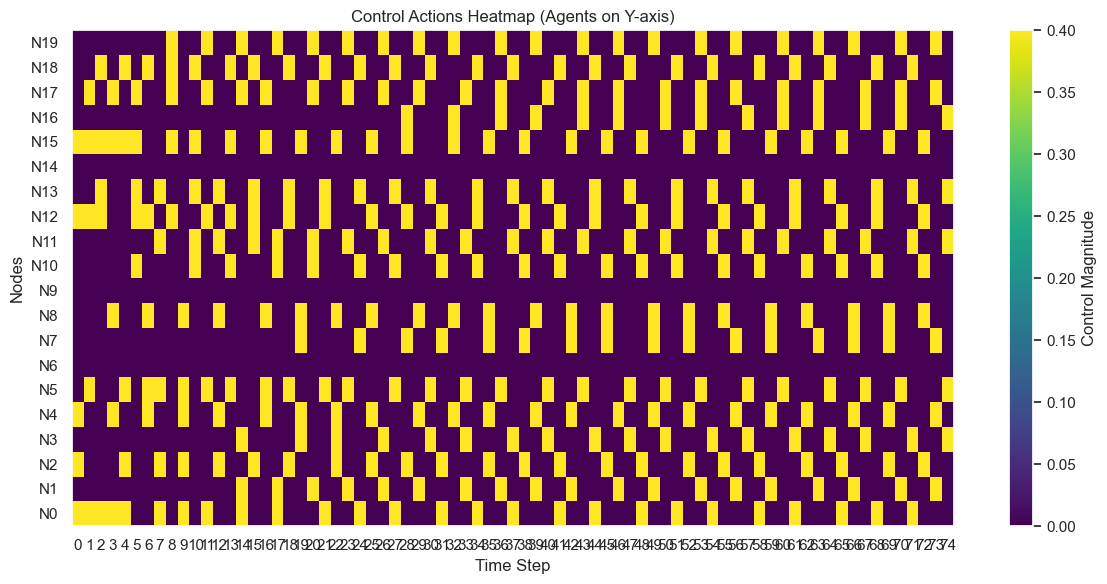

In [11]:
plot_action_heatmap(actions)

In [12]:
actions

array([[0.40000001, 0.        , 0.39999998, ..., 0.        , 0.        ,
        0.        ],
       [0.40000001, 0.        , 0.        , ..., 0.40000001, 0.        ,
        0.        ],
       [0.40000001, 0.        , 0.        , ..., 0.        , 0.40000001,
        0.        ],
       ...,
       [0.        , 0.        , 0.40000001, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.40000001, 0.        , ..., 0.39999998, 0.        ,
        0.40000001],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [13]:
# Not feasable with lots of nodes

# env = build_environment()

# # Adjusted parameters
# step_duration = env.tau
# max_total_budget = 2
# action_levels = [0, 0.4]

# V = value_iteration(env, 
#                     action_levels=action_levels,
#                     nx=nx, 
#                     gamma=gamma,  
#                     step_duration=step_duration, 
#                     max_total_budget=max_total_budget)
# policy = extract_policy(
#     env, 
#     V, 
#     action_levels=action_levels, 
#     nx=nx, gamma=gamma, 
#     step_duration=step_duration, 
#     max_total_budget=max_total_budget
# )

In [14]:
# for node_index in range(env.num_agents):
#     visualize_policy_from_env(policy, env, nx=nx, node_index=node_index)

In [15]:
# env = build_environment()
# num_steps = 30

# opinions_over_time, time_points, rewards = run_policy(env, policy, nx=nx, step_duration=env.tau, max_steps=num_steps)
# plot_opinions_over_time(opinions_over_time)
# # sum(rewards)

# total_value = 0
# for i, r in enumerate(rewards):
#     total_value = total_value + (gamma**i) * r
    
# total_value

In [16]:
# env.opinions

In [17]:
# rewards

### DQN: 
Distributes budget beta_k (beta can be selected from discrete interval) across all nodes using W*
beta_k to be chosen constant

###  NAHS 
Distributes total budget B across M campaigns
At each campaign distributes the budget beta_k across all nodes using W_k
distribute the same beta_k as in the dqn experiment, and track